In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
m = 500
n = 500
r = min(m, n)
eigenvals = np.logspace(0, -2, r)
D = np.zeros((r, r))
np.fill_diagonal(D, eigenvals)
U, _ = sp.linalg.qr(np.random.standard_normal(size=(m, r)), mode="economic")
V, _ = sp.linalg.qr(np.random.standard_normal(size=(n, r)), mode="economic")
A = U @ D @ V.T

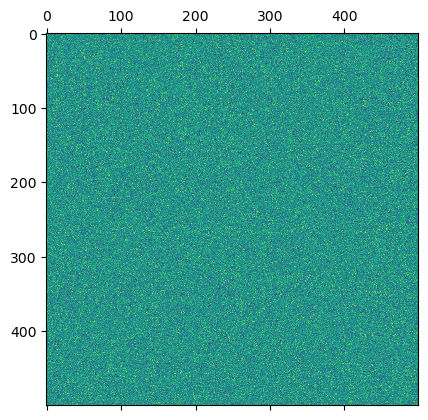

In [28]:
plt.matshow(A)

In [43]:
def err(A, reconstructed):
    return np.linalg.norm(A - reconstructed, ord="fro")

def reconstruct(U, S, V, k):
    return U[:, :k] @ np.diag(S[:k]) @ V[:k, :]

def get_omega(A, k, p=0):
    """
    k: rank
    p: oversampling
    """
    return np.random.normal(0, 1, (A.shape[1], k+p))

def power_iters(A, Omega, power_iter=2):
    
    Y = A @ Omega
    for q in range(power_iter):
        Y = A @ A.T @ Y
    Q, _ = np.linalg.qr(Y)
    
    return Q

def adaptive_range_finder(A, eps, max_iters):
    
    B = Q.T @ A
    
    A_ = A
    Q_ = np.array([])
    B_ = B
    i = 0
    norm_A = np.linalg.norm(A_, ord="fro")
    while norm_A >= eps and i < max_iters:
        i += 1
        g = np.random.normal(size=[A.shape[1], 1])
        y = A_ @ g
        q = y / np.linalg.norm(y, ord="fro")
        b = q.T @ A_
        if i > 1:
            Q_ = np.hstack((Q_, q))
        else:
            Q_ = np.copy(q)
        B_ = np.hstack((B_.T, b.T)).T
        A_ = A_ - q @ b
        norm_A = np.linalg.norm(A_, ord="fro")
    
        approx_err = A - (Q_ @ Q_.T @ A_)
        B_ = Q_.T @ A
    
    
    return Q_, i

def direct_svd(A, Q):
    
    B = Q.T @ A
    U_tilde, S, V = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    
    return U, S, V


def direct_svd_enhanced(A, Q, factorization="eig"):
    B = Q.T @ A
    if factorization == "eig":
        T = B @ B.T
        D, U_hat = np.linalg.eig(T)
        S = np.sqrt(D)
        V = B.T @ U_hat @ np.linalg.inv(np.diag(S))
        U = Q @ U_hat
        return U, S, V.T
    elif factorization == "qr":
        Q_tilde, R_tilde = np.linalg.qr(B.T)
        U_tilde, S, V_tilde = np.linalg.svd(R_tilde)
        V = Q_tilde @ U_tilde
        U = Q @ V_tilde
        return U, S, V.T

In [6]:
%%time
u, s, v = np.linalg.svd(A, full_matrices=False)

CPU times: total: 266 ms
Wall time: 70.1 ms


In [34]:
%%time

k = int(0.1 * A.shape[1]) #rank
p = 5
omega = get_omega(A, k, p)

Q = power_iters(A, omega, 0)
u, s, v = direct_svd(A, Q)
assert reconstruct(u, s, v, k).shape == A.shape

CPU times: total: 62.5 ms
Wall time: 21.9 ms


In [8]:
%%time

k = int(0.1 * A.shape[1]) #rank
p = 5
omega = get_omega(A, k, p)

Q = power_iters(A, omega, 0)
u, s, v = direct_svd_enhanced(A, Q, "eig")
assert reconstruct(u, s, v, k).shape == A.shape

CPU times: total: 0 ns
Wall time: 10.1 ms


In [23]:
%%time

k = int(0.1 * A.shape[1]) #rank
p = 5
omega = get_omega(A, k, p)

Q = power_iters(A, omega, 0)
u, s, v = direct_svd_enhanced(A, Q, "qr")
assert reconstruct(u, s, v, k).shape == A.shape

CPU times: total: 15.6 ms
Wall time: 14.5 ms


In [24]:
%%time

Q, k = adaptive_range_finder(A, eps=5e-2, max_iters=100)
u, s, v = direct_svd(A, Q)
assert reconstruct(u, s, v, k).shape == A.shape

CPU times: total: 2.55 s
Wall time: 680 ms


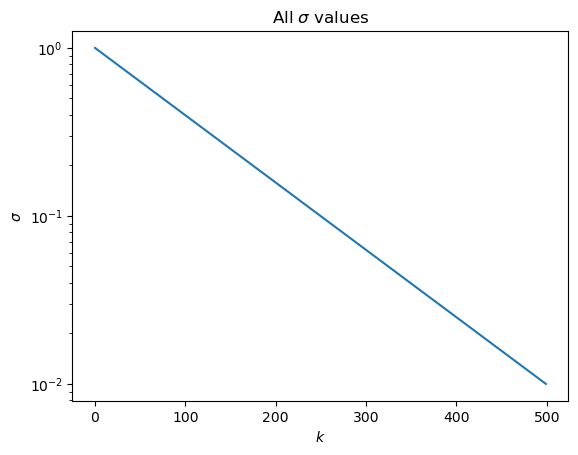

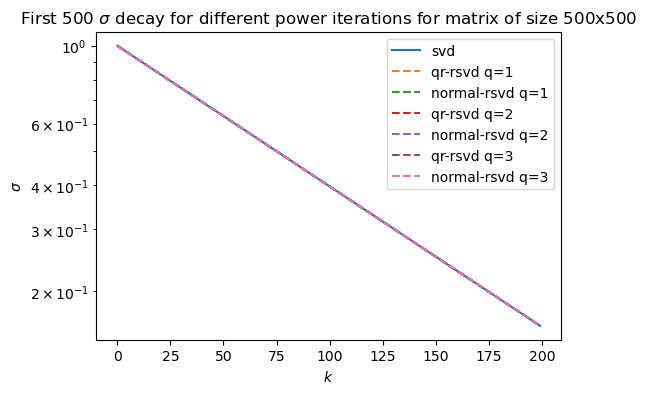

In [25]:
k = A.shape[1]
max_ = 200
omega = get_omega(A, k, p=0)
U, S, V = np.linalg.svd(A, full_matrices=False)
s = S.flatten()
plt.figure()
plt.semilogy(s, label="svd")
plt.title("All $\sigma$ values")
plt.ylabel("$\sigma$")
plt.xlabel("$k$")
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogy(s[:k][:max_], label="svd")
for q in range(1, 4):
    # k = int(scale * A.shape[1])
    Q = power_iters(A, omega, q)
    _, S2, _ = direct_svd_enhanced(A, Q, factorization="qr")
    s2 = S2.flatten()
    plt.semilogy(s2[:max_], label=f"qr-rsvd q={q}", linestyle="--")
    _, S3, _ = direct_svd(A, Q)
    s3 = S3.flatten()
    plt.semilogy(s3[:max_], label=f"normal-rsvd q={q}", linestyle="--")
plt.legend()
plt.ylabel("$\sigma$")
plt.xlabel("$k$")
plt.title(f"First {k} $\sigma$ decay for different power iterations for matrix of size {A.shape[0]}x{A.shape[1]}")
plt.show()

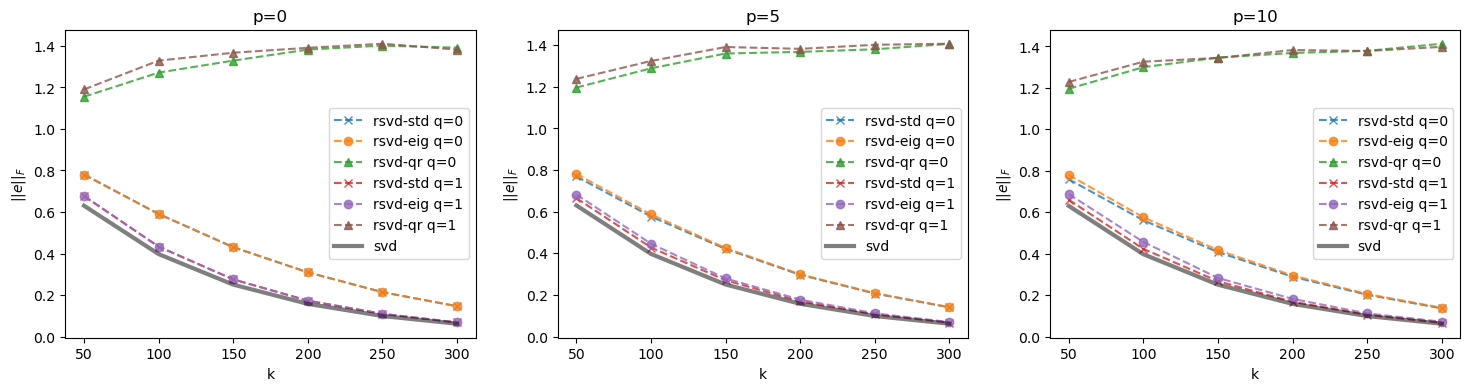

In [26]:
p = 10
q = 1
cutoff = 100
# max_k = int(0.3 * A.shape[1])
ranks = np.arange(50, 301, 50)
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
U, S, V = np.linalg.svd(A, full_matrices=False)
norm_A = np.linalg.norm(A, ord="fro")
for i, p in enumerate([0, 5, 10]):
    for q in range(0, 2):
        svd_norms = []
        rsvd_norms1 = []
        rsvd_norms2 = []
        rsvd_norms3 = []
        for k in ranks:    
            omega = get_omega(A, k, p)
            Q = power_iters(A, omega, q)
            U1, S1, V1 = direct_svd(A, Q)
            U2, S2, V2 = direct_svd_enhanced(A, Q, "eig")
            U3, S3, V3 = direct_svd_enhanced(A, Q, "qr")
            svd_norms.append(err(A, reconstruct(U, S, V, k)))
            rsvd_norms1.append(err(A, reconstruct(U1, S1, V1, k)))
            rsvd_norms2.append(err(A, reconstruct(U2, S2, V2, k)))
            rsvd_norms3.append(err(A, reconstruct(U3, S3, V3, k)))
            
            
        ax[i].plot(ranks, rsvd_norms1/norm_A, label=f"rsvd-std q={q}", linestyle="--", alpha=.8, marker="x")
        ax[i].plot(ranks, rsvd_norms2/norm_A, label=f"rsvd-eig q={q}", linestyle="--", alpha=.8, marker="o")
        ax[i].plot(ranks, rsvd_norms3/norm_A, label=f"rsvd-qr q={q}", linestyle="--", alpha=.8, marker="^")
    ax[i].plot(ranks, svd_norms/norm_A, label=f"svd", color="black", linewidth=3, alpha=0.5)
    # ax[i].axvline(x=cutoff, color="black", alpha=.5, label=f"k={cutoff}")
    ax[i].set_title(f"p={p}")
    ax[i].legend()
    ax[i].set_xlabel("k")
    # ax[i].set_yscale("log")
    # ax[i].set_ylabel("${\lVert e \rVert}_F$")
    ax[i].set_ylabel("$\|\|e\|\|_F$")
plt.show()

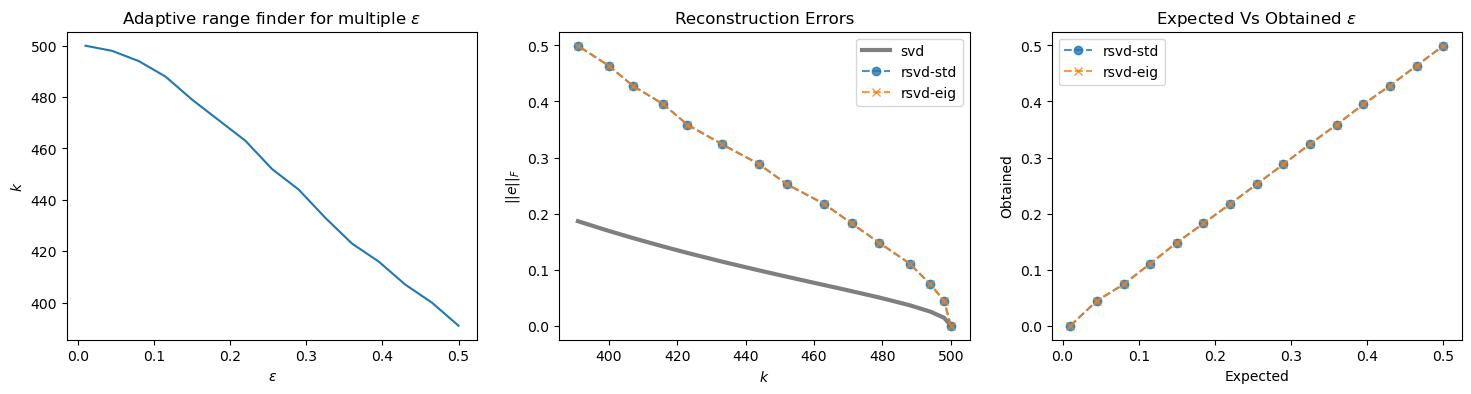

In [32]:
epsilons = np.linspace(0.01, 0.5, 15)
U, S, V = np.linalg.svd(A, full_matrices=False)
norm_A = np.linalg.norm(A, ord="fro")
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
svd_norms = []
rsvd_norms1 = []
rsvd_norms2 = []
rsvd_norms3 = []
ranks = []

for eps in epsilons:    
    Q, k = adaptive_range_finder(A, eps, A.shape[1])
    ranks.append(k)
    U1, S1, V1 = direct_svd(A, Q)
    U2, S2, V2 = direct_svd_enhanced(A, Q, "eig")
    svd_norms.append(err(A, reconstruct(U, S, V, k)))
    rsvd_norms1.append(err(A, reconstruct(U1, S1, V1, k)))
    rsvd_norms2.append(err(A, reconstruct(U2, S2, V2, k)))

ax[0].plot(epsilons, ranks)
ax[0].set_title(f"Adaptive range finder for multiple $\epsilon$")
ax[0].set_xlabel("$\epsilon$")
ax[0].set_ylabel("$k$")
# ax[0].set_xscale("log")

ax[1].plot(ranks, svd_norms, label="svd", alpha=0.5, linewidth=3, color="black")
ax[1].plot(ranks, rsvd_norms1, label="rsvd-std", alpha=0.8, linestyle="--", marker="o")
ax[1].plot(ranks, rsvd_norms2, label="rsvd-eig", alpha=0.8, linestyle="--", marker="x")
ax[1].set_title("Reconstruction Errors")
ax[1].set_xlabel("$k$")
ax[1].set_ylabel("$\|\|e\|\|_F$")
# ax[1].set_yscale("log")
ax[1].legend()

# ax[2].plot(epsilons, svd_norms, label="svd", alpha=0.5, linewidth=3, color="black")
ax[2].plot(epsilons, rsvd_norms1, label="rsvd-std", alpha=0.8, linestyle="--", marker="o")
ax[2].plot(epsilons, rsvd_norms2, label="rsvd-eig", alpha=0.8, linestyle="--", marker="x")
ax[2].set_title("Expected Vs Obtained $\epsilon$")
ax[2].set_xlabel("Expected")
ax[2].set_ylabel("Obtained")
ax[2].legend()
plt.show()

In [41]:
k = -1

print("k =", ranks[k], "\tMatrix shape:", A.shape)
print("svd", svd_norms[k])
print("rsvd-std", rsvd_norms1[k])
print("rsvd-eig", rsvd_norms2[k])

k = 391 	Matrix shape: (500, 500)
svd 0.18646782311859142
rsvd-std 0.4994781588279855
rsvd-eig 0.49947815882798546


In [75]:
def partial_cpqr(A, k, approx_err=False):
    
def ID(A, k, approx_err=False):
    
    Q, S, J = sp.linalg.qr(A, pivoting=True)
    Q1, Q2 = Q[:, :k], Q[:, k:]
    S11, S12 = S[:k,:k], S[:k,k:]
    S22 = S[k:, k:]
    P = np.eye(A.shape[0])[J]
    T = np.linalg.inv(S11) @ S12
    Z = np.hstack((np.eye(k), T)) @ P.T
    A_hat = A[:, J[:k]] @ Z
    
    if approx_err:
        return A_hat, np.linalg.norm(A - A_hat), np.linalg.norm(S22)
    return A_hat
# plt.spy(ID(A, 100))
# A[250:260, 250:260] = 1
A_hat, approx_err, err_bound = ID(A, 500, True)
# plt.matshow(A); plt.show()
# plt.matshow(A_hat); plt.show()

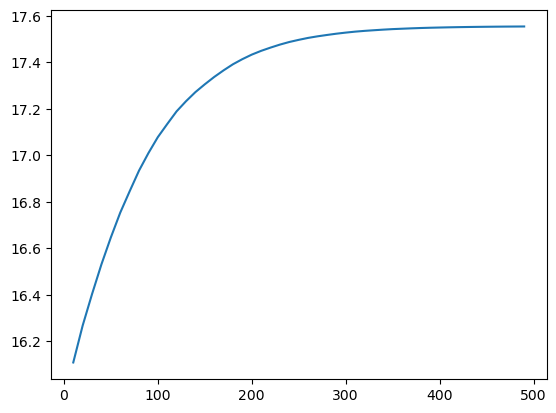

In [76]:
ranks = np.arange(10, A.shape[1], 10)
errs = []
for k in ranks:
    A_hat, approx_err, err_bound = ID(A, k, True)
    errs.append(approx_err)
plt.plot(ranks, errs)